Ref:https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Importing datetime.
from datetime import datetime
import seaborn as sns
import pickle  # Python pickle API to serialize your machine learning algorithms and save the serialized format to a file
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
plt.style.use('fivethirtyeight')

Data:
    

In [2]:
vax = pd.read_csv('trainv.csv')

In [3]:
vax[:5]

,date,hospital,item,qty
0,01/01/21,1,1,13
1,02/01/21,1,1,11
2,03/01/21,1,1,14
3,04/01/21,1,1,13
4,05/01/21,1,1,10


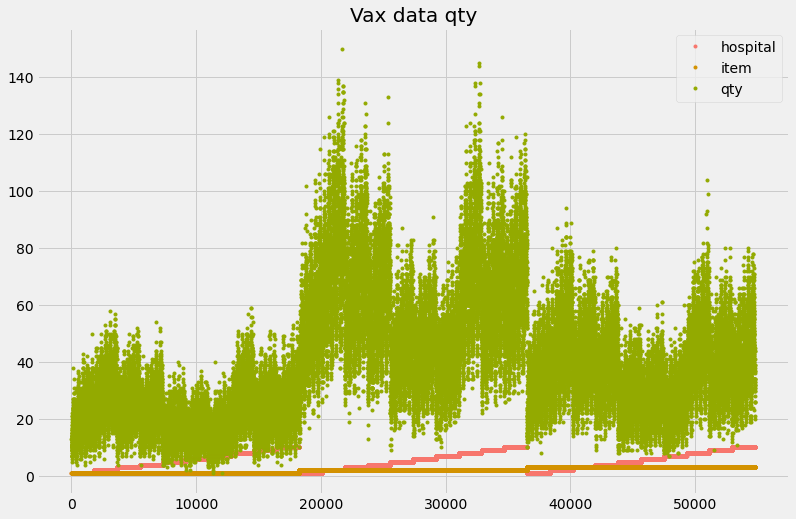

In [4]:
# Data visualization
color_pal = ["#F8766D", "#D39200", "#93AA00"]
_ = vax.plot(style='.', figsize=(12,8), color=color_pal[:3], title='Vax data qty')

Splitting Vax data into Train/Test 

In [5]:
# splitting dataframe by row index

vax_test = vax.iloc[45001:,:]
vax_train = vax.iloc[:45000,:]
print("Shape of new dataframes - {} , {}".format(vax_train.shape, vax_test.shape))



#X_train , X_test ,y_train, y_test = train_test_split(vax.drop('qty',axis=1),vax.pop('qty'), random_state=123, test_size=0.2)

Shape of new dataframes - (45000, 4) , (9779, 4)


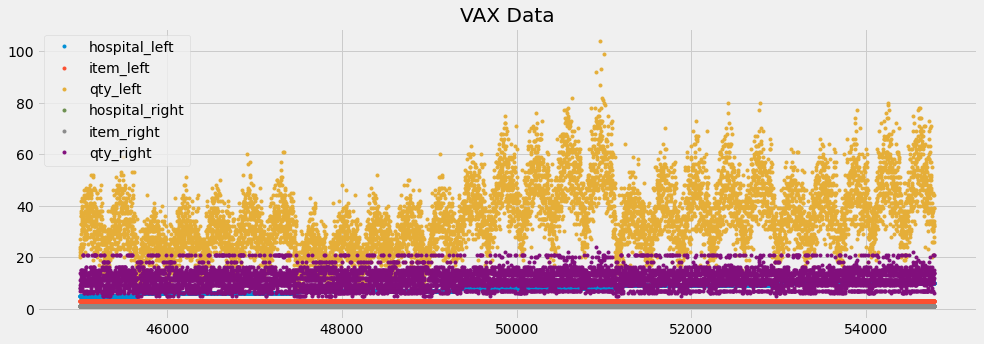

In [6]:
_ = vax_test \
    .rename(columns={'date':'TEST_Date'
                     }) \
    .join(vax_train.rename(columns={'date':'TRAIN_Date'
                              }),on='qty', lsuffix='_left', rsuffix='_right') \
    .plot(figsize=(15,5), title='VAX Data', style='.')

In [7]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = pd.to_datetime(df['date'])
    #df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    #df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hospital','item','dayofweek','month','year',
           'dayofyear','dayofmonth','weekofyear']]
           
    if label:
        y = df[label]
        return X, y
    return X

In [8]:
X_train, y_train = create_features(vax_train, label='qty')
X_test, y_test = create_features(vax_test, label='qty')

<ipython-input-7-2434058b248e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
<ipython-input-7-2434058b248e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df['date'].dt.dayofweek
<ipython-input-7-2434058b248e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

 We will creat some time series features to see how the trends are impacted by day of week, hour, time of year, etc.

In [9]:
X_train.shape,X_test.shape


((45000, 8), (9779, 8))

In [10]:
X_train[:5]

,hospital,item,dayofweek,month,year,dayofyear,dayofmonth,weekofyear
0,1,1,4,1,2021,1,1,53
1,1,1,0,2,2021,32,1,5
2,1,1,0,3,2021,60,1,9
3,1,1,3,4,2021,91,1,13
4,1,1,5,5,2021,121,1,17


Creating XGBoost Model

In [11]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [12]:
# save model to file
#pickle.dump(reg, open("vax.pickle.dat", "wb"))

Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the hospital was most commonly used to split trees, while item and day came in next. Weekofyear has low importance due to the fact that it could be created by same year splits. 

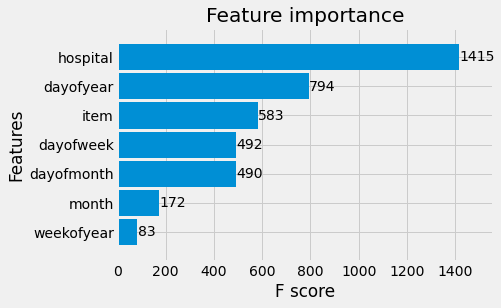

In [13]:
_ = plot_importance(reg, height=0.9)

Forecast on Test Set

In [14]:
vax_test['VD_Prediction'] = reg.predict(X_test)
vax_all = pd.concat([vax_test, vax_train], sort=False)

<ipython-input-14-692e5f75ca81>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vax_test['VD_Prediction'] = reg.predict(X_test)


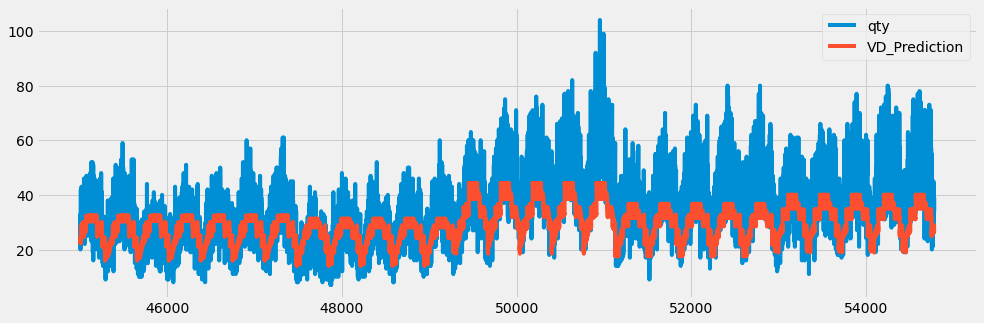

In [15]:
_ = vax_test[['qty','VD_Prediction']].plot(figsize=(15, 5))

Look at first month of predictions

Error Metrics On Test Set

 RMSE error is 142.70543
 
 MAE error is 9.04747
 
 MAPE error is 24.25%

In [17]:
mean_squared_error(y_true=vax_test['qty'],
                   y_pred=vax_test['VD_Prediction'])

142.70543462228244

In [18]:
mean_absolute_error(y_true=vax_test['qty'],
                   y_pred=vax_test['VD_Prediction'])

9.047473836376668

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are. MAPE isn't included in sklearn so we need to use a custom function.

In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
mean_absolute_percentage_error(y_true=vax_test['qty'],
                   y_pred=vax_test['VD_Prediction'])

24.258751490183133

In [21]:
vax_test['error'] = vax_test['qty'] - vax_test['VD_Prediction']
vax_test['abs_error'] = vax_test['error'].apply(np.abs)
error_by_day = vax_test.groupby(['year','month','dayofmonth']) \
    .mean()[['qty','VD_Prediction','error','abs_error']]

<ipython-input-21-54c3b1c6c089>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vax_test['error'] = vax_test['qty'] - vax_test['VD_Prediction']
<ipython-input-21-54c3b1c6c089>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vax_test['abs_error'] = vax_test['error'].apply(np.abs)


In [22]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(3)

qty  VD_Prediction     error  abs_error
year month dayofmonth                                               
2021 3     29          28.648148      26.994534  1.653614   6.948126
     1     30          22.269231      20.444609  1.824623   6.002351
     2     24          24.538462      22.598753  1.939708   4.758038

Notice anything about the over forecasted days?

#1 worst day - Feb 6th, 2021 - saturday 
#2 worst day - March 6th, 2021 - Staurday

Looks like our model may benefit from adding a holiday indicator.

In [23]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(3)

qty  VD_Prediction     error  abs_error
year month dayofmonth                                               
2021 3     2           25.000000      21.091305  3.908696   4.634412
     12    1           24.307692      21.371315  2.936377   4.732508
     2     24          24.538462      22.598753  1.939708   4.758038

Up next?¶
Add Lag variables
Add holiday indicators.
Add weather data source.

In [24]:
# load model from file
#loaded_model = pickle.load(open("vax.pickle.dat", "rb"))

In [28]:
# make predictions for test data
#y_pred = loaded_model.predict(X_test) # load data processed data to test model
#predictions = [round(value) for value in y_pred]
# evaluate predictions
#mean_squared_error(y_test, predictions)


142.60732181204622

In [30]:
#Saving model

In [29]:
with open('vax_model.pkl', 'wb') as f:
    pickle.dump(reg, f)

In [31]:
# loading  model
with open('vax_model.pkl', 'rb') as f:
    reg_loaded=pickle.load(f)

In [32]:
reg_loaded

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
reg_loaded.predict(X_test)

array([22.263573, 22.263573, 22.263573, ..., 28.893858, 26.565145,
       26.565145], dtype=float32)

In [36]:
X_test

,hospital,item,dayofweek,month,year,dayofyear,dayofmonth,weekofyear
45001,5,3,1,3,2021,82,23,12
45002,5,3,2,3,2021,83,24,12
45003,5,3,3,3,2021,84,25,12
45004,5,3,4,3,2021,85,26,12
45005,5,3,5,3,2021,86,27,12
...,...,...,...,...,...,...,...,...
54775,10,3,5,3,2021,86,27,12
54776,10,3,6,3,2021,87,28,12
54777,10,3,0,3,2021,88,29,13
54778,10,3,1,3,2021,89,30,13
